In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.double)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [13]:
TARGET_SHAPE = "sphere" # chose from ["sphere", "triangle"]
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]


In [14]:
traj = torch.load("../retrosynth/optim_traj_%s.pkl"%TARGET_SHAPE, map_location=torch.device('cpu'))
grid_comps = traj["grid_comps"]
grid_loss = traj["grid_loss"].detach().numpy()*10

target_x = traj["target_x"].squeeze()
target_y = traj["target_y"]

In [15]:
if TARGET_SHAPE=="sphere":
    RESTRAT_INDEX = 2
    expt = np.load("../retrosynth/sphere_measured.npz")
else:
    RESTRAT_INDEX = 1
    expt = np.load("../retrosynth/triangle_measured.npz")
    
trajectory = traj["X_traj"][RESTRAT_INDEX,...]

In [16]:
def prettify_spectra(ax):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Intensity (normalized)")
    
def min_max_scale(y):
    return (y-min(y))/(max(y)-min(y))

def unscale_wavelength(wl, limits=[400, 900]):
    return wl*(limits[1]-limits[0]) + limits[0]

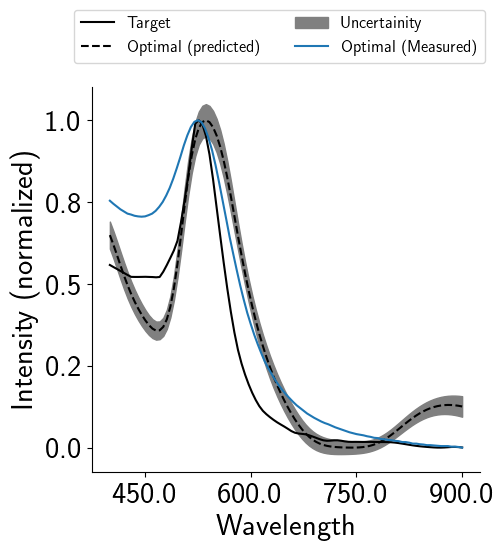

In [17]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(unscale_wavelength(target_x), 
            min_max_scale(target_y.squeeze().numpy()), 
            c="k", label="Target")
    optim_spectra = traj["spectra"][RESTRAT_INDEX,...]
    mu = min_max_scale(optim_spectra[:,0].numpy())
    sigma = optim_spectra[:,1].numpy()
    ax.plot(unscale_wavelength(target_x), 
            mu, 
            c="k", ls="--", label="Optimal (predicted)")
    ax.fill_between(unscale_wavelength(target_x),
                    mu-sigma, 
                    mu+sigma, 
                    color='grey',
                    label="Uncertainity"
                    )
    if 'expt' in locals():
        y_measured = expt["spectra"][RESTRAT_INDEX,:]
        ax.plot(expt["wav"], min_max_scale(y_measured), label="Optimal (Measured)")
    prettify_spectra(ax)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, 
               loc='upper center', 
               bbox_to_anchor=[0.5,1.05], prop={'size': 12}
               )
    plt.savefig("./figures/target_pred_comparision_%s.png"%TARGET_SHAPE)
    plt.show()

In [18]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1870/1474876256.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


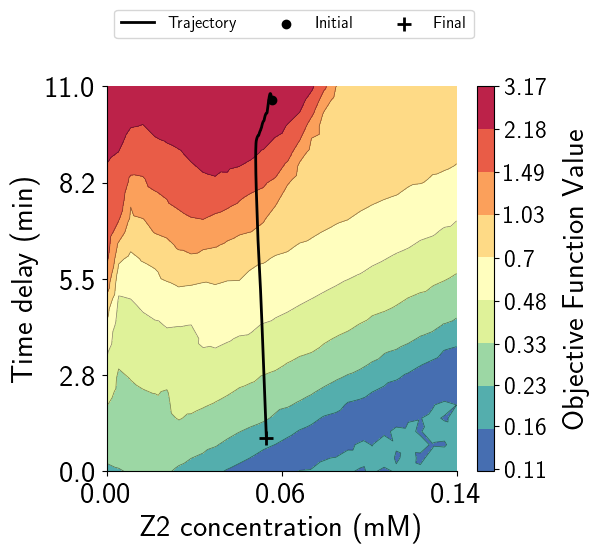

In [19]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    levs = np.geomspace(grid_loss.min(), grid_loss.max(), num=10)
    fun = ax.tricontourf(grid_comps[:,0],
                         grid_comps[:,1],
                         grid_loss,
                         levs,
                         cmap='Spectral_r',
                         locator=ticker.LogLocator(),
                         )
    ax.tricontour(grid_comps[:,0],
                  grid_comps[:,1],
                  grid_loss,
                  levs,
                  colors='k',
                  linewidths=0.5,
                  alpha=0.5
                  )

    ax.plot(trajectory[:,0], trajectory[:,1],lw=2,c='k', label="Trajectory")
    ax.scatter(trajectory[0,0], trajectory[0,1],s=100,c='k',marker='.',zorder=10,lw=2, label="Initial")
    ax.scatter(trajectory[-1,0], trajectory[-1,1],s=100,c='k',marker='+',zorder=10,lw=2, label="Final")
    prettify_axis(ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    ticks = np.round(levs,2)
    cbar = fig.colorbar(fun, cax=cax, orientation='vertical')
    cbar.set_label(label='Objective Function Value', labelpad=12)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(ticks, fontsize=18)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, ncols=3,
               loc='upper center', 
               bbox_to_anchor=[0.5,1.05], prop={'size': 12}
               )
    plt.savefig("./figures/optimization_trajectory_%s.png"%TARGET_SHAPE)
    plt.show()

In [20]:
print("Optimal Z2 volume : ", trajectory[-1,0])
print("Optimal Z2 concentration : ", (0.3*trajectory[-1,0])/(280.0-trajectory[-1,0]))
print("Time delay optimal : ", trajectory[-1,1])

Optimal Z2 volume :  tensor(39.7240)
Optimal Z2 concentration :  tensor(0.0496)
Time delay optimal :  tensor(0.9608)


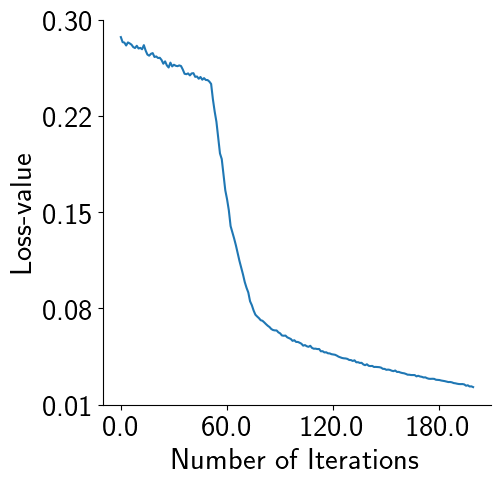

In [21]:
loss_traj = traj["loss"][RESTRAT_INDEX,...]
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(np.arange(loss_traj.shape[0]), loss_traj)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Loss-value")
    plt.savefig("./figures/lossfunc_trajectory_%s.png"%TARGET_SHAPE)
    plt.show()

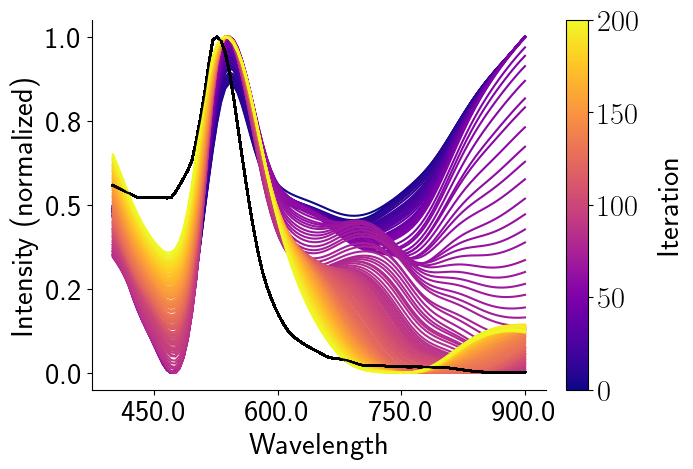

In [22]:
spectra_traj = traj["spectra_traj"][RESTRAT_INDEX,...]
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("plasma")
    norm = Normalize(vmin=0, vmax = spectra_traj.shape[0])
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    for i in range(spectra_traj.shape[0]):
        ax.plot(unscale_wavelength(target_x), 
                min_max_scale(spectra_traj[i,:,0].numpy()), 
                color=cmap(norm(i))
                )
        ax.plot(unscale_wavelength(target_x), 
                min_max_scale(target_y.squeeze().numpy()), 
                c="k", label="Target"
                )
    prettify_spectra(ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(label='Iteration', labelpad=12)
    plt.savefig("./figures/spectra_trajectory_%s.png"%TARGET_SHAPE)
    plt.show()